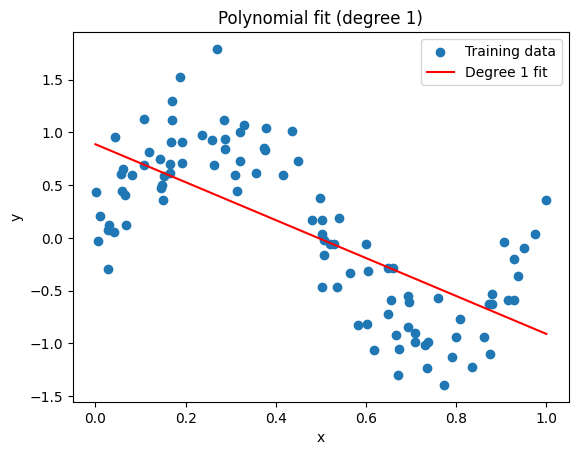

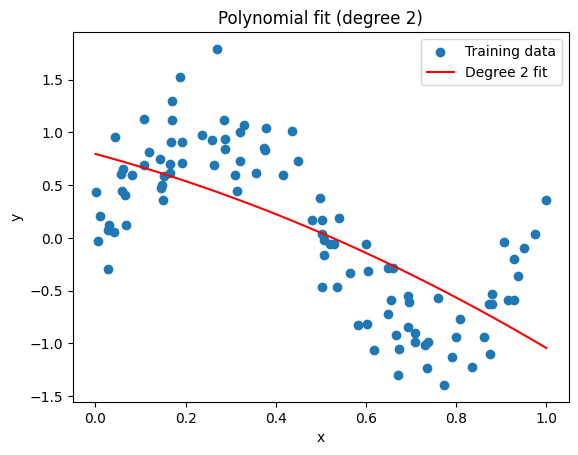

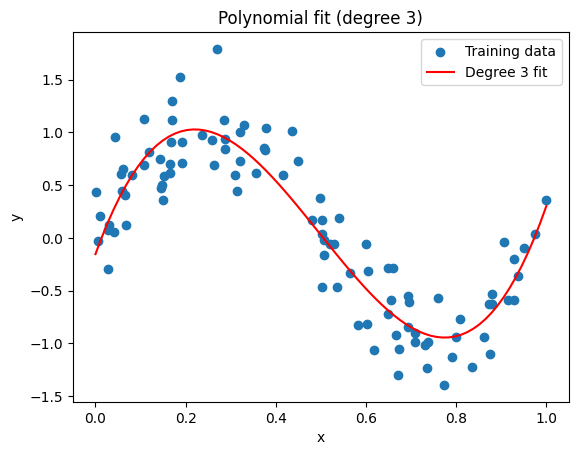

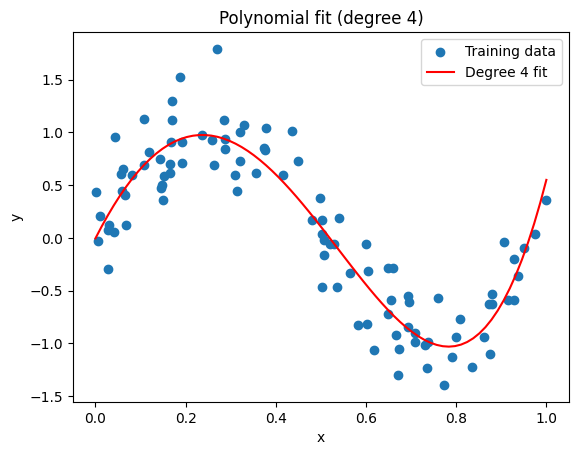

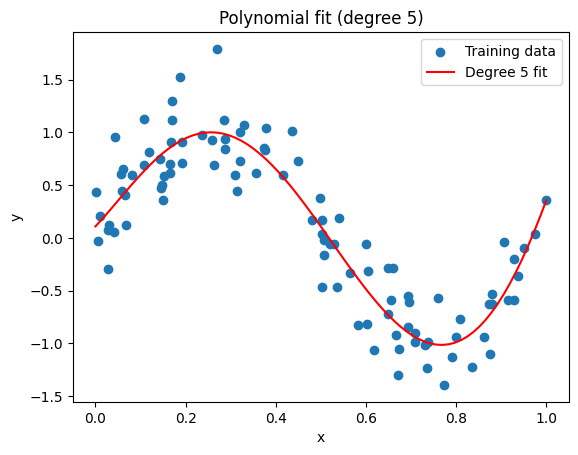

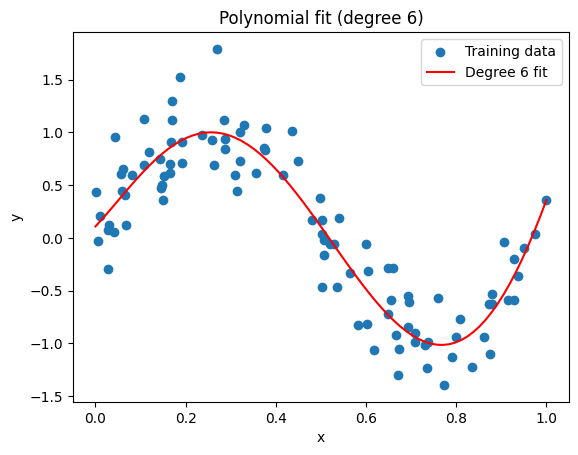

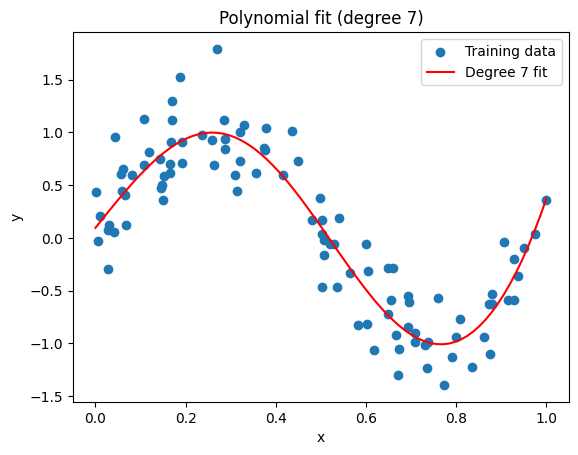

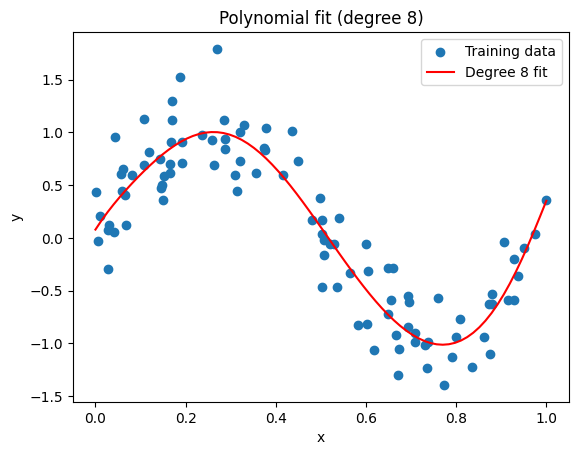

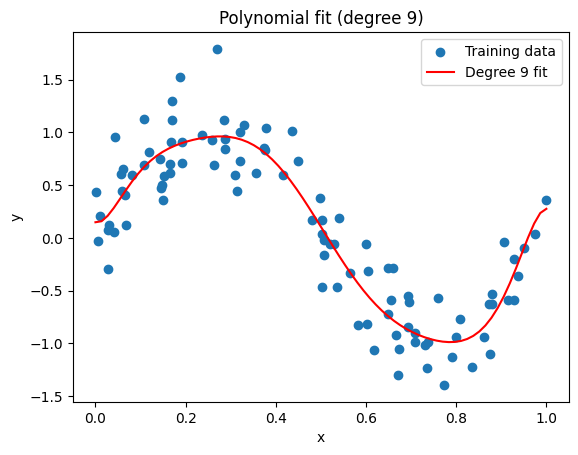

In [218]:
import numpy as np
import matplotlib.pyplot as plt
N = 100

x = np.random.uniform(0, 1, N)
xx = np.linspace(0,1,75)
noise = np.random.normal(0, 0.3, N)
y = np.sin(2 * np.pi * x) + noise
#Polynomial fitting
for M in range(1, 10):
    coeffs = np.polyfit(x, y, M)
    poly = np.poly1d(coeffs)
    y_fit = poly(xx)

    plt.figure()
    plt.scatter(x, y, label="Training data")
    plt.plot(xx, y_fit, label=f"Degree {M} fit", color = 'red')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"Polynomial fit (degree {M})")
    plt.legend()
    plt.show()

### Analysis of Activity 1
- a) As we increase the degree of polynomial, the fitting gets better. As we increase the number of data points, the chance of overfitting decreases.

In [219]:
#comparing erms with sigma for M=9 and N=100

M = 9
coeffs = np.polyfit(x, y, M)
poly = np.poly1d(coeffs)
y_pred = poly(x)

erms = np.sqrt(np.mean((y_pred - y)**2))
print("Noise sigma:", 0.3)
print("ERMS of model:", erms)

Noise sigma: 0.3
ERMS of model: 0.27883339104480814


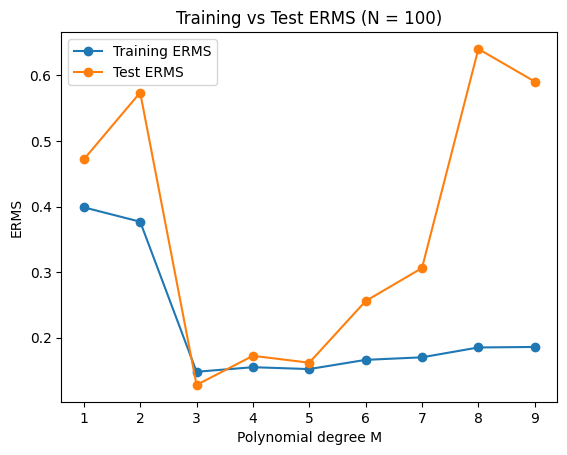

In [220]:
#train and test of erms
from sklearn.model_selection import train_test_split

# split data
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.75, random_state=0
)

erms_train = []
erms_test = []

for M in range(1, 10):
    p = np.poly1d(np.polyfit(x_train, y_train, M))

    erms_train.append(
        np.sqrt(np.mean((p(x_train) - np.sin(2*np.pi*x_train))**2))
    )
    erms_test.append(
        np.sqrt(np.mean((p(x_test) - np.sin(2*np.pi*x_test))**2))
    )
plt.figure()
plt.plot(range(1, 10), erms_train, 'o-', label="Training ERMS")
plt.plot(range(1, 10), erms_test, 'o-', label="Test ERMS")
plt.xlabel("Polynomial degree M")
plt.ylabel("ERMS")
plt.title("Training vs Test ERMS (N = 100)")
plt.legend()
plt.show()

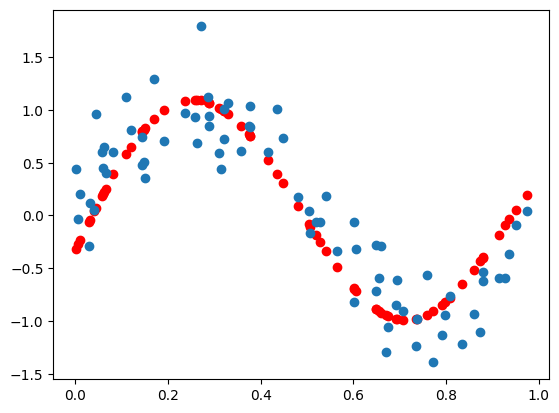

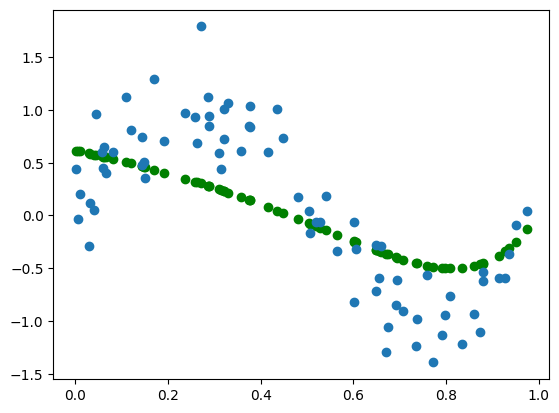

In [221]:
#REGULARIZATION
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

model1 = Pipeline([
    ("poly", PolynomialFeatures(degree = 9, include_bias =  False)),
    ("ridge", Ridge(alpha = 2**(-18)))
])

model2 = Pipeline([
    ("poly", PolynomialFeatures(degree = 9, include_bias =  False)),
    ("ridge", Ridge(alpha = 1))
])

model1.fit(x_train.reshape(-1,1), y_train)
y_pred1 = model1.predict(x_test.reshape(-1,1))
model2.fit(x_train.reshape(-1,1), y_train)
y_pred2 = model2.predict(x_test.reshape(-1,1))

#Plots
plt.scatter(x_test, y_pred1, label=f"ln λ = -18", color = 'red')
plt.scatter(x_test, y_test)
plt.show()

plt.scatter(x_test, y_pred2, label=f"ln λ = 0", color = 'green')
plt.scatter(x_test, y_test)
plt.show()

### Analysis for Activity 2
- a) When lambda is very large, it underfits as the w^2 part becomes the dominating factor while minimizing the error term, resulting in a almost constant y (horizontal green plot). When ln(lambda) is -18 (an optimised value), it suppresses the overfitting and gives a good fit.

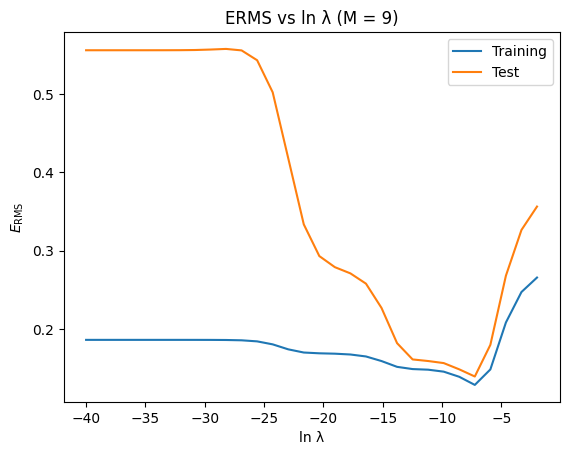

In [224]:
ln_lambdas = np.linspace(-40, -2, 30)
erms_train_reg = []
erms_test_reg = []

for lnlam in ln_lambdas:
    lam = np.exp(lnlam)
    model = Pipeline([
        ("poly", PolynomialFeatures(degree = 9, include_bias =  False)),
        ("ridge", Ridge(alpha = lam))
    ])
    model.fit(x_train.reshape(-1,1), y_train)

    y_train_pred = model.predict(x_train.reshape(-1,1))
    y_test_pred  = model.predict(x_test.reshape(-1,1))

    erms_train_reg.append(
        np.sqrt(np.mean((y_train_pred - np.sin(2*np.pi*x_train))**2))
    )
    erms_test_reg.append(
        np.sqrt(np.mean((y_test_pred - np.sin(2*np.pi*x_test))**2))
    )

# -----------------------------
# Plot
# -----------------------------
plt.figure()
plt.plot(ln_lambdas, erms_train_reg, label="Training")
plt.plot(ln_lambdas, erms_test_reg, label="Test")
plt.xlabel("ln λ")
plt.ylabel(r"$E_{\mathrm{RMS}}$")
plt.title("ERMS vs ln λ (M = 9)")
plt.legend()
plt.show()

### Analysis of Activity 2
- b) When lambda is very small, it starts to overfit.

### Analysis for Activity 3
- P(A|+) = $\frac{P(+|A)P(A)}{P(+|A)P(A)+P(+|not A)P(not A)} = \frac{0.98*0.001}{0.98*0.001+0.03*0.999} = 0.03$
  Hence, the probability is very low to get worried with a positive test.

- a) Likelihood = P(+|A) = 0.98

- b) Baysian prior = P(A) = 0.001

- c) No

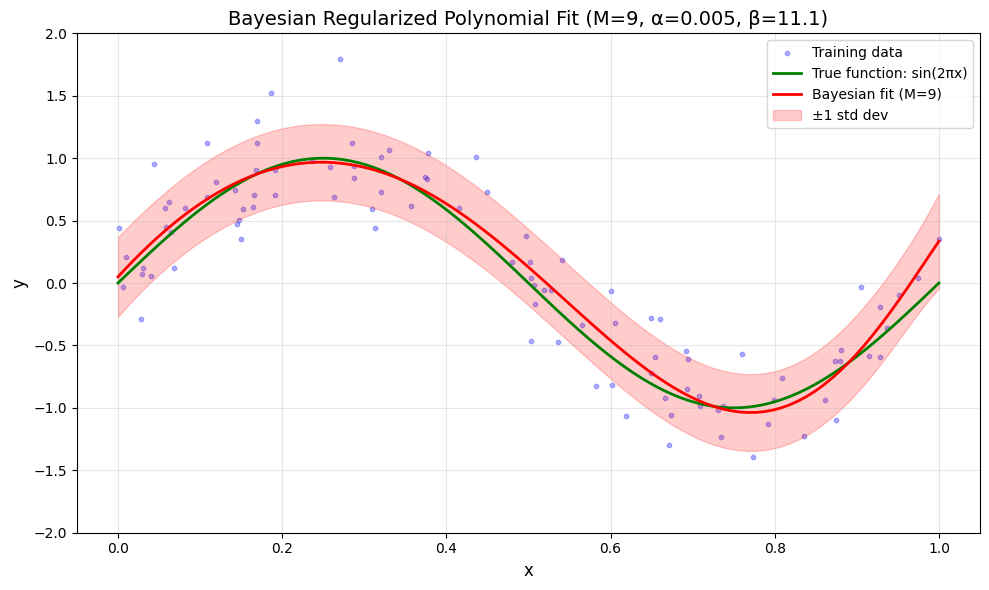

In [223]:
#Activity 4
# Uses α (alpha) to control how much we penalize large coefficients (regularization)
# Uses β (beta) to control how much we trust the data (inverse noise variance)
# Key formulas:

# m_N = β × S_N × Φ^T × t (formula 1.70) - gives us the mean coefficients
# S_N = (α×I + β×Φ^T×Φ)^(-1) (formula 1.72) - gives us the covariance (uncertainty)

#Where Φ is the design matrix (polynomial features).
# Step 1: Parameters from assignment

M = 9  # Polynomial degree
alpha = 5e-3  # 5 × 10^-3 (regularization parameter)
beta = 11.1   # Precision of noise

# Step 2: Create design matrix Φ (Phi)
# Each row is [1, x, x^2, x^3, ..., x^M] for polynomial basis
def design_matrix(x, M):
    N = len(x)
    Phi = np.zeros((N, M + 1))
    for i in range(M + 1):
        Phi[:, i] = x ** i
    return Phi

Phi = design_matrix(x, M)

# Step 3: Compute S_N (covariance matrix) - Formula 1.72
# S_N = (α*I + β*Φ^T*Φ)^(-1)
I = np.eye(M + 1)  # Identity matrix
S_N = np.linalg.inv(alpha * I + beta * Phi.T @ Phi)
# np.linalg.inv computes the matrix inverse, and @ performs matrix multiplication

# Step 4: Compute m_N (mean of posterior) - Formula 1.70
# m_N = β * S_N * Φ^T * t
m_N = beta * S_N @ Phi.T @ y

# Step 5: Make predictions for plotting
x_test = np.linspace(0, 1, 100)
Phi_test = design_matrix(x_test, M)
y_pred = Phi_test @ m_N

# Step 6: Compute predictive variance (for uncertainty bands)
# σ²(x) = 1/β + φ(x)^T * S_N * φ(x) - Formula 1.71
y_var = np.zeros(len(x_test))
for i in range(len(x_test)):
    phi_x = Phi_test[i, :]
    y_var[i] = 1/beta + phi_x.T @ S_N @ phi_x

y_std = np.sqrt(y_var)
#print(y_std)

# Step 7: Plot results (similar to Figure 1.17)
plt.figure(figsize=(10, 6))

# Plot training data
plt.scatter(x, y, alpha=0.3, s=10, color='blue', label='Training data')
# (This alpha here controls transparency.)


# Plot true function
x_true = np.linspace(0, 1, 100)
y_true = np.sin(2 * np.pi * x_true)
plt.plot(x_true, y_true, 'g-', linewidth=2, label='True function: sin(2πx)')

# Plot Bayesian prediction
plt.plot(x_test, y_pred, 'r-', linewidth=2, label=f'Bayesian fit (M={M})')

# Plot uncertainty (±1 standard deviation)
plt.fill_between(x_test, y_pred - y_std, y_pred + y_std, 
                 color='red', alpha=0.2, label='±1 std dev')

plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title(f'Bayesian Regularized Polynomial Fit (M={M}, α={alpha}, β={beta})', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(-2, 2)
plt.tight_layout()
plt.show()

### Analysis of Activity 4
- a) $\beta = \frac{1}{\sigma^2} = \frac{1}{0.3^2} = 11.1$ Hence, $\beta = 11.1$ should be expected from this data.
- b) Frequentist curve fitting treats model parameters as fixed but unknown and finds a single best-fit solution by minimizing a loss function, with regularization added externally if needed. Bayesian curve fitting treats parameters as random variables and combines a likelihood with a prior to obtain a posterior distribution. As a result, Bayesian fitting naturally incorporates regularization through the prior. It also provides predictive uncertainty, whereas frequentist fitting typically gives only point estimates.